## Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from math import sqrt
from joblib import dump, load

## Instanciando objetos da etapa anterior

In [2]:
# Carrega o dataframe salvo previamente

df_airbnb_ml = pd.read_csv('airbnb_ml.csv', index_col='id', engine='python', sep =',', encoding="utf-8")

In [3]:
# Carrega o modelo treinado salvo previamente

regr = load('regressor.joblib')

## Particionando os dados

In [4]:
# Define semente aleatória, para garantir a reproducibilidade dos resultados

random_state=1223614

# Vamos dividir da seguinte forma: 90% para treino e 10% para teste. 
# Os registros deverão ser embaralhados.

X = df_airbnb_ml.drop(columns=['price'])
y = df_airbnb_ml['price']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.1, random_state=random_state)

print("Quantidade de registros de X_train: " + str(X_train.shape[0]))
print("Quantidade de registros de y_train: " + str(y_train.shape[0]))
print("Quantidade de registros de X_test: " + str(X_test.shape[0]))
print("Quantidade de registros de y_test: " + str(y_test.shape[0]))

Quantidade de registros de X_train: 6300
Quantidade de registros de y_train: 6300
Quantidade de registros de X_test: 700
Quantidade de registros de y_test: 700


## Testando a performance do modelo

In [5]:
# Calcula métricas de desempenho do regressor.

def get_metrics(y_test, y_pred):  

    rmse = round(sqrt(mean_squared_error(y_test, y_pred)),4)
    r2 = round(r2_score(y_test, y_pred),4)

    return rmse, r2

In [6]:
# Avalia a performance do modelo treinado, usando a massa reservada para testes.
# E obtém as métricas de desempenho - o quanto nosso modelo acertou?

# RMSE (Raiz do erro médio quadrático - Quanto mais próximo a 0.0000, melhor)
# R² (Coeficiente de determinação - Quanto mais  próximo a 1.0000, melhor)

y_pred = regr.predict(X_test)
rmse, r2 = get_metrics(y_test, y_pred)
comparacao = []
comparacao.append(('Regressor Otimizado', rmse, r2))
print('RMSE: ',rmse)
print('R²: ',r2)

RMSE:  99.9141
R²:  0.4468


In [7]:
# Comparando os resultados com o LinearRegression, o nosso algoritmo de base.

linear_regr = LinearRegression()
linear_regr.fit(X_train, y_train)
y_pred_baseline = linear_regr.predict(X_test)
rmse, r2 = get_metrics(y_test, y_pred_baseline)
comparacao.append(('Regressor Básico', rmse, r2))
print('RMSE: ',rmse)
print('R²: ',r2)

RMSE:  104.9229
R²:  0.3899


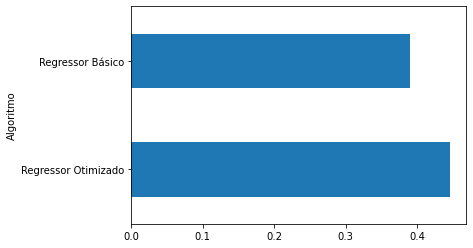

In [8]:
df_comparacao = pd.DataFrame(data=comparacao, columns=['Algoritmo', 'RMSE', 'R2'])
df_comparacao.set_index('Algoritmo', inplace=True)
df_comparacao.sort_values('R2', ascending=False, inplace=True)
df_comparacao['R2'].plot.barh()

In [9]:
melhoria = ((df_comparacao.loc['Regressor Otimizado']['R2'] / df_comparacao.loc['Regressor Básico']['R2']) - 1) * 100
print('Melhoria obtida com a otimização do modelo, segundo a métrica R²: ' + str(round(melhoria, 4)) + ' %')

Melhoria obtida com a otimização do modelo, segundo a métrica R²: 14.5935 %


## Avaliando os resultados obtidos

In [10]:
# Exemplo de visualização de dados

df_resultados = pd.DataFrame(np.array(y_test).flatten(),columns=['realizado'])
df_resultados['previsto'] = np.array(y_pred)
df_resultados['id'] = X_test.index
df_resultados = df_resultados[['id', 'realizado', 'previsto']]
df_resultados

,id,realizado,previsto
0,10279456,504.0,411.156672
1,12863588,500.0,169.973076
2,4981423,189.0,212.870532
3,8796046,235.0,127.347407
4,826814,193.0,153.845564
...,...,...,...
695,27927610,202.0,172.226099
696,829813,214.0,225.723728
697,28686711,197.0,175.719296
698,31743204,319.0,176.110518


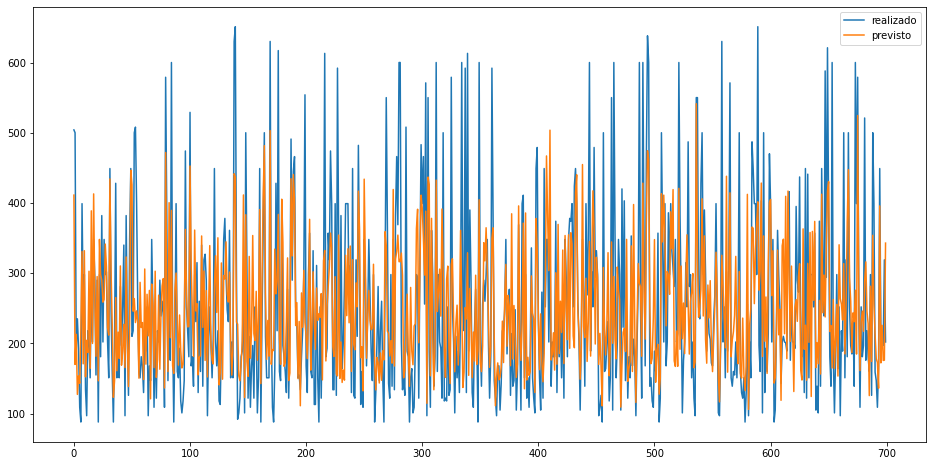

In [11]:
df_resultados[['realizado', 'previsto']][:].plot(kind='line', figsize=(16,8))

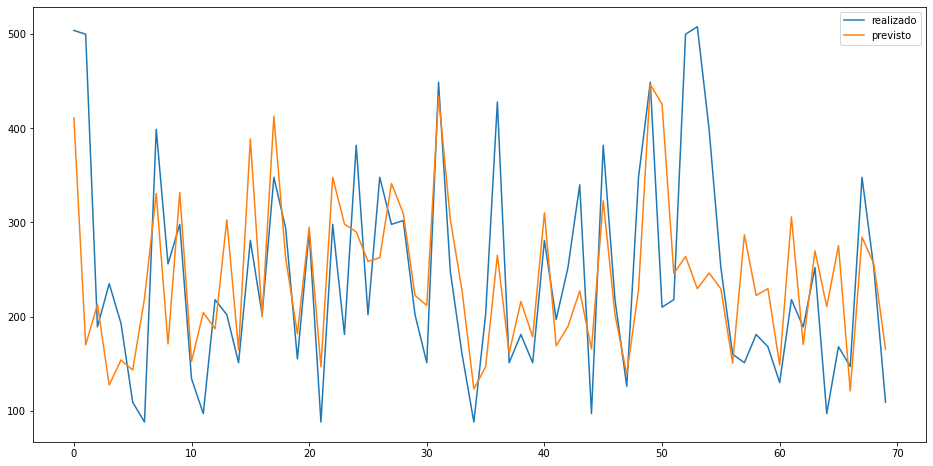

In [12]:
df_resultados[['realizado', 'previsto']][0:70].plot(kind='line', figsize=(16,8))

## Medindo a diferença entre os valores previstos e realizados

In [13]:
df_resultados['diferenca_relativa'] = (df_resultados['realizado'] / df_resultados['previsto']) - 1
df_resultados.set_index('id', inplace=True)
df_resultados.sort_values('diferenca_relativa', inplace=True)
df_resultados

,realizado,previsto,diferenca_relativa
id,,,
13166901,122.0,391.350396,-0.688259
22610275,88.0,242.143235,-0.636579
2325943,97.0,263.608207,-0.632030
23819207,88.0,219.157451,-0.598462
34507967,92.0,227.473785,-0.595558
...,...,...,...
3197436,588.0,237.648787,1.474239
31960056,420.0,168.947873,1.485974
12863588,500.0,169.973076,1.941642


In [14]:
anuncios_baratos = df_resultados[['diferenca_relativa']]
anuncios_baratos.query('diferenca_relativa < 0', inplace = True)

In [15]:
anuncios_baratos

,diferenca_relativa
id,
13166901,-0.688259
22610275,-0.636579
2325943,-0.632030
23819207,-0.598462
34507967,-0.595558
...,...
21850822,-0.014756
10170491,-0.014667
584211,-0.011648


In [16]:
# Diferença relativa ideal

diferenca_ideal = round(float(anuncios_baratos['diferenca_relativa'].mean()),6)
print("diferença relativa ideal: " + str(diferenca_ideal * 100) + " %")

diferença relativa ideal: -24.232 %


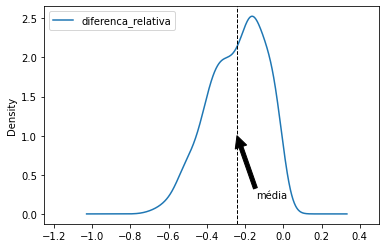

In [17]:
# Distribuição da diferença de preços (realizado - previsto) dos anúncios baratos

anuncios_baratos.plot.density(xlim=(-1.25, 0.5))\
    .annotate('média', xy=(diferenca_ideal, 1), xytext=(diferenca_ideal+0.1, 0.2), arrowprops=dict(facecolor='black'))
plt.axvline(diferenca_ideal, color='k', linestyle='dashed', linewidth=1)

##### Diferença pequena demais significa que o anúncio não está tão barato assim e não oferece uma oportunidade boa de economia.
##### Diferença grande demais significa que o anúncio provavelmente possui alguma característica negativa não mapeada.
##### Ou seja: Algum atributo negativo que o algoritmo não identificou ou não utilizou na predição do valor.
##### Então: Diferenças muito pequenas ou muito grandes devem piorar a pontuação do anúncio no ranking.
##### A diferença ideal deve ser a média, a partir da qual as distâncias serão calculadas.
##### Quanto mais próximo da diferença ideal, melhor o 'custo-benefício' do anúncio.
##### E quanto maior o custo-benefício, melhor a pontuação do anúncio no ranking.

## Criando ranking para ordenar os anúncios com base no custo-benefício

In [18]:
# Os anúncios com valor mais próximo da diferença ideal entre os valores previstos e realizados terão um melhor score.

distancia_da_diferenca_ideal = abs(diferenca_ideal - df_resultados['diferenca_relativa'])
distancia_min_da_diferenca_ideal = 0
distancia_max_do_valor_mais_barato = abs(diferenca_ideal - df_resultados.quantile([0])['diferenca_relativa'].tolist()[0])
distancia_max_do_valor_mais_caro = abs(diferenca_ideal - df_resultados.quantile([1])['diferenca_relativa'].tolist()[0])
distancia_max_da_diferenca_ideal = max(distancia_max_do_valor_mais_barato, distancia_max_do_valor_mais_caro)
distancia_invertida = distancia_max_da_diferenca_ideal - distancia_da_diferenca_ideal

df_resultados['ranking'] = distancia_invertida / distancia_max_da_diferenca_ideal
df_resultados.sort_values('ranking', ascending=False, inplace=True)
df_resultados[['realizado', 'previsto', 'diferenca_relativa', 'ranking']]

,realizado,previsto,diferenca_relativa,ranking
id,,,,
25953323,197.0,260.190190,-0.242862,0.999825
7626969,252.0,332.931869,-0.243088,0.999752
5325370,126.0,166.661286,-0.243976,0.999465
32671767,210.0,276.459231,-0.240394,0.999378
34564320,218.0,288.653801,-0.244770,0.999208
...,...,...,...,...
3197436,588.0,237.648787,1.474239,0.445172
31960056,420.0,168.947873,1.485974,0.441379
12863588,500.0,169.973076,1.941642,0.294097


## Exibindo os melhores anúncios do ranking

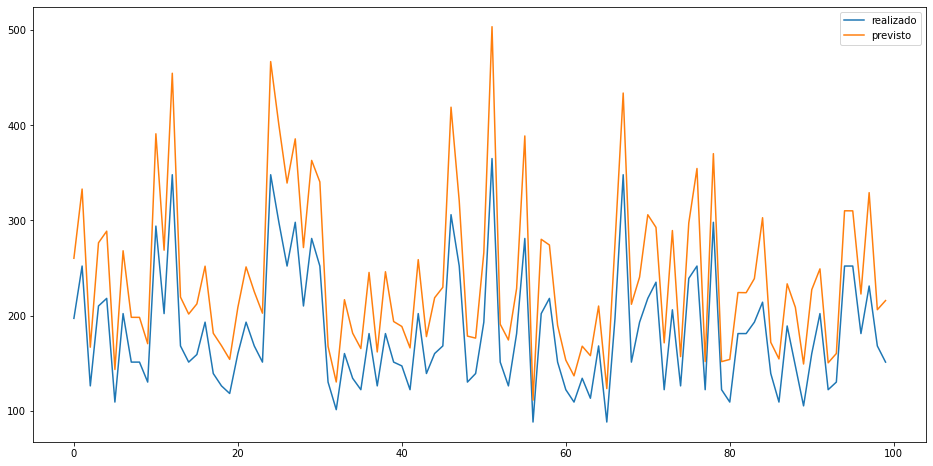

In [19]:
df_resultados.reset_index()[['realizado', 'previsto']][0:100].plot(kind='line', figsize=(16,8))

## Exibindo os piores anúncios do ranking

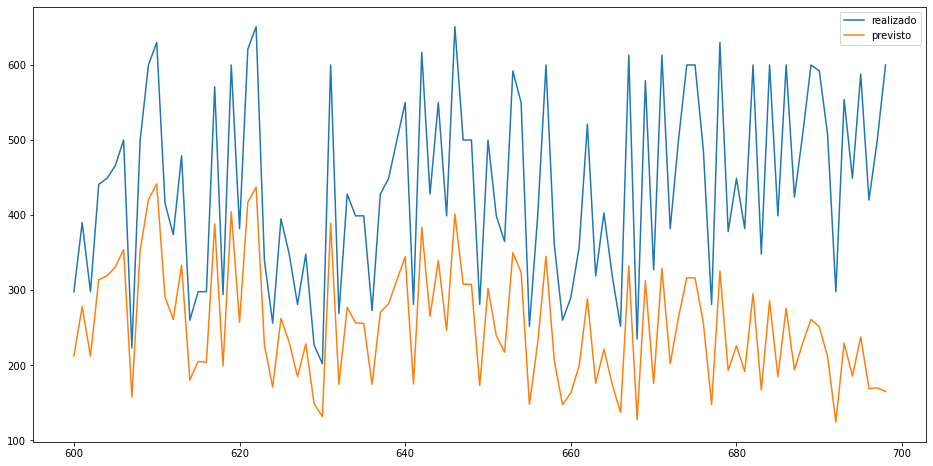

In [20]:
df_resultados.reset_index()[['realizado', 'previsto']][-100:-1].plot(kind='line', figsize=(16,8))

## Salvando os resultados para as próximas etapas

In [21]:
df_resultados.to_csv('resultados.csv')